In [ ]:

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


# from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。
from util import *

In [2]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [ ]:
# # implementation of PINNsformer
# # paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# # link: https://arxiv.org/abs/2307.11833

# import torch
# import torch.nn as nn
# import pdb

# from util import get_clones


# #自定义激活函数Wavelet：w1 * sin(x) + w2 * cos(x)
# class WaveAct(nn.Module):
#     def __init__(self):
#         super(WaveAct, self).__init__() 
#         #自定义两个可学习参数w1和w2，初始化为1，训练过程中会更新这两个参数
#         self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
#         self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

#     def forward(self, x):
#         return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

# #MLP组件，第一层形状为(d_model, d_ff)，第二层形状为(d_ff, d_ff)，第三层形状为(d_ff, d_model)，前两个使用自定义激活函数WaveAct
# class FeedForward(nn.Module):
#     def __init__(self, d_model, d_ff=256):
#         super(FeedForward, self).__init__() 
#         self.linear = nn.Sequential(*[
#             nn.Linear(d_model, d_ff),
#             WaveAct(),
#             nn.Linear(d_ff, d_ff),
#             WaveAct(),
#             nn.Linear(d_ff, d_model)
#         ])

#     def forward(self, x):
#         return self.linear(x)

# #编码器层
# class EncoderLayer(nn.Module):
#     def __init__(self, d_model, heads):
#         super(EncoderLayer, self).__init__()
#         self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) #多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
#         self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
#         self.act1 = WaveAct() #激活函数
#         self.act2 = WaveAct() #激活函数
        
#     def forward(self, x): #形状为(点的数量，序列长度，d_model)
#         x2 = self.act1(x) #对输入x应用激活函数
#         # pdb.set_trace()
#         x = x + self.attn(x2,x2,x2)[0] #多头注意力机制，查询、键和值均为原始输入经过激活函数后的x2，然后使用残差连接原始输入得到自注意力的输出
#         x2 = self.act2(x) #对自注意力的输出应用激活函数
#         x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到编码器的输出
#         return x 


# class DecoderLayer(nn.Module):
#     def __init__(self, d_model, heads):
#         super(DecoderLayer, self).__init__()
#         self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True) # 多头注意力，设置嵌入维度为d_model，头数为heads，batch_first=True表示输入和输出tensor以(批量大小,序列长度,嵌入维度) 形式提供
#         self.ff = FeedForward(d_model) #MLP组件，输入和输出的形状均为d_model，隐藏层的形状为d_ff默认
#         self.act1 = WaveAct() #激活函数
#         self.act2 = WaveAct() #激活函数

#     def forward(self, x, e_outputs): #输入形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
#         x2 = self.act1(x) #将解码器输入x通过激活函数
#         x = x + self.attn(x2, e_outputs, e_outputs)[0] #多头注意力机制，查询为解码器输入经过激活函数后的x2，键和值为编码器的输出e_outputs，然后使用残差连接原始输入得到自注意力的输出
#         x2 = self.act2(x) #将自注意力的输出通过激活函数
#         x = x + self.ff(x2) #将通过激活函数后的自注意力输出通过MLP组件后残差连接原始自注意力输出，得到解码器的输出
#         return x

# #编码器层，包含多个堆叠的编码器架构
# class Encoder(nn.Module):
#     def __init__(self, d_model, N, heads): #参数N代表编码器的头数，N代表包含几个编码器，d_model是数据的嵌入维度（用于每个编码器），heads是头的数量
#         super(Encoder, self).__init__()
#         self.N = N 
#         self.layers = get_clones(EncoderLayer(d_model, heads), N) #N个编码器
#         self.act = WaveAct()

#     def forward(self, x): #输入一次通过N个编码器，x的形状为(点的数量，序列长度，d_model)
#         for i in range(self.N):
#             x = self.layers[i](x)
#         return self.act(x) #编码器的输出要经过激活函数

# #解码器层，包含多个堆叠的解码器架构
# class Decoder(nn.Module):
#     def __init__(self, d_model, N, heads): #参数N代表解码器的头数，N代表包含几个解码器，d_model是数据的嵌入维度（用于每个解码器），heads是头的数量
#         super(Decoder, self).__init__()
#         self.N = N
#         self.layers = get_clones(DecoderLayer(d_model, heads), N) #N个解码器
#         self.act = WaveAct()
        
#     def forward(self, x, e_outputs): #输入一次通过N个解码器层，x的形状为(点的数量，序列长度，d_model)，e_outputs为编码器的输出，形状也是为(点的数量，序列长度，d_model)
#         for i in range(self.N): #输入和编码器输出依次通过N个解码器
#             x = self.layers[i](x, e_outputs) 
#         return self.act(x) #解码器的输出要经过激活函数



# class DNN(nn.Module):
#     def __init__(self, d_out, d_model, d_hidden, N, heads): #接受参数为：d_out代表整个模型的输出的维度（就是最后的mlp层的输出维度），d_model代表每个点的特征嵌入维度，d_hidden代表最后的output layer模块中的隐藏层的维度，N代表编码器和解码器的层数，heads代表多头注意力机制的头数
#         super(DNN, self).__init__()

#         self.linear_emb = nn.Linear(2, d_model) #线性层，将输入的2维数据映射到d_model维度

#         self.encoder = Encoder(d_model, N, heads) #编码器层
#         self.decoder = Decoder(d_model, N, heads) #解码器层

#         #输出的mlp模块，包含三个线性层，前两个使用自定义激活函数WaveAct，最终将feature从d_model维度映射到d_hidden维度，最后将d_hidden维度映射到d_out维度
#         self.linear_hidden = nn.Sequential(*[
#             nn.Linear(d_model, d_hidden),
#             WaveAct(),
#             nn.Linear(d_hidden, d_hidden),
#             WaveAct(),
#             nn.Linear(d_hidden, 2),
#         ])
#         self.linear_out = nn.Sequential(*[
#             WaveAct(),
#             nn.Linear(2, d_out)
#         ])

#     def forward(self, x): #输入的x形状一般为(点的数量, 序列长度, 2)
#         src = x #形状为(点的数量，序列长度，2)
#         src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

#         e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
#         d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
#         output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
#         output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
#         # pdb.set_trace()
#         # raise Exception('stop')
#         return output #(点的数量，序列长度，d_out)
    
#     # 新增方法，获取最后一个隐藏层的输出
#     def hidden_output(self, x):
#         src = x #形状为(点的数量，序列长度，2)
#         src = self.linear_emb(src) #特征向量通过第一个线性层，映射到高维，此时src的形状为(点的数量，序列长度，d_model)，d_model代表每个点的特征

#         e_outputs = self.encoder(src) #编码器处理输入特征向量，得到编码后的输出，形状为(点的数量，序列长度，d_model)
#         d_output = self.decoder(src, e_outputs) #解码器处理输入特征向量和编码后的输出，得到解码后的输出，形状为(点的数量，序列长度，d_model)
#         output_hidden = self.linear_hidden(d_output) #解码后的输出通过输出的mlp模块，得到最终的预测结果。形状为(点的数量，序列长度，2)，d_out代表输出的维度
#         # output = self.linear_out(output_hidden) #形状为(点的数量，序列长度，d_out)，d_out代表输出的维度
#         # pdb.set_trace()
#         # raise Exception('stop')
#         return output_hidden #(点的数量，序列长度，2)

    
   

In [ ]:
# #set the class of PINN

# #定义了一个名为`PhysicsInformedNN'的类，用于实现基于物理的神经网络。
# class PhysicsInformedNN:
#     # Initialize the class
#     def __init__(self, x0, u0, tb, X_f, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        
#         X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
#         X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
#         X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值

#         X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
#         X_lb = make_time_sequence(X_lb, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
#         X_ub = make_time_sequence(X_ub, num_step=5, step=1e-4)
#         X_f = make_time_sequence(X_f, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)


#         # self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
#         self.lb = torch.tensor(lb, dtype=torch.float64, requires_grad=True).to(device)
#         # self.ub = torch.tensor(ub).float().to(device)
#         self.ub = torch.tensor(ub, dtype=torch.float64, requires_grad=True).to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。

#         self.x0 = torch.tensor(X0[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device)
#         self.t0 = torch.tensor(X0[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。

#         self.x_lb = torch.tensor(X_lb[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device) #将X_lb的第一列赋值给self.x_lb
#         self.t_lb = torch.tensor(X_lb[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device)

#         self.x_ub = torch.tensor(X_ub[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device) #将X_ub的第一列赋值给self.x_ub
#         self.t_ub = torch.tensor(X_ub[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device)

#         self.x_f = torch.tensor(X_f[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device) #将X_f的第一列赋值给self.x_f
#         self.t_f = torch.tensor(X_f[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device) #将X_f的第二列赋值给self.t_f

#         self.u0 = torch.tensor(u0, dtype=torch.float64).to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。

#         # self.x0 = torch.tensor(X0[:,:, 0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
#         # self.t0 = torch.tensor(X0[:,:, 1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

#         # self.x_lb = torch.tensor(X_lb[:,:, 0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
#         # self.t_lb = torch.tensor(X_lb[:,:, 1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

#         # self.x_ub = torch.tensor(X_ub[:,:, 0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
#         # self.t_ub = torch.tensor(X_ub[:,:, 1:2], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
#         # self.x_f = torch.tensor(X_f[:,:, 0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
#         # self.t_f = torch.tensor(X_f[:,:, 1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
#         # self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。
        
        
        
        
#         # deep neural networks
#         # self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device) 
#         self.dnn = DNN(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(torch.float64).to(device) #创建一个DNN对象，传入参数d_out=1, d_hidden=512, d_model=32, N=1, heads=2，表示输出维度为1，隐藏层维度为512，嵌入维度为32，编码器和解码器的层数为1，头数为2。并将这个DNN对象移动到指定的设备上（GPU或CPU）。
#         self.dnn.apply(self.init_weights) #初始化模型中线性层的权重和偏置



#         self.optimizer_LBFGS = torch.optim.LBFGS(self.dnn.parameters(), line_search_fn='strong_wolfe')
#         #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
#         self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
                

#         self.iter = 0 #记录迭代次数 

#         self.loss_value = [] #创建一个空列表，用于存储损失值

#     def init_weights(self, m):
#         if isinstance(m, nn.Linear): #判断是否是线性层
#             torch.nn.init.xavier_uniform(m.weight)
#             m.bias.data.fill_(0.01)
    
#     #这个函数与下面的net_u函数功能相同，只是不计算梯度，因为在记录每个epoch的error时，使用with torch.no_grad()情况下调用net_u函数会报错，不知道为啥？
#     def net_u_error(self, x, t):  
#         u = self.dnn(torch.cat([x, t], dim=-1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        
#         return u #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


#     #pytorch中
#     #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
#     def net_u(self, x, t):  
#         u = self.dnn(torch.cat([x, t], dim=-1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u

#         u_x = torch.autograd.grad(
#             u, x, 
#             grad_outputs=torch.ones_like(u),
#             retain_graph=True,
#             create_graph=True
#         )[0]

#         return u,u_x #两个输出(点的数量，序列长度，1)


#     #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
#     def net_f(self, x, t):
#         """ The pytorch autograd version of calculating residual """

#         u,u_x=self.net_u(x,t) #调用上面的函数/方法，计算神经网络的输出（两个）以及输出关于输入x的梯度（两个）
        
#         #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
#         u_t = torch.autograd.grad(
#             u, t,  #输入的张量，要计算u关于t的导数
#             grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
#             retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
#             create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
#         )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

#         u_xx = torch.autograd.grad(
#             u_x, x, 
#             grad_outputs=torch.ones_like(u_x),
#             retain_graph=True,
#             create_graph=True
#         )[0]
        
#         f=u_t-0.0001*u_xx+5*u**3-5*u    #计算f,定义见论文

#         return f  #(点的数量，序列长度，1)


#     def loss_func(self):
#         self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）

#         u0_pred, _  = self.net_u(self.x0, self.t0) #输出(点的数量，序列长度，1)
#         u0_pred = u0_pred[:,0:1].reshape(-1,1) #(点的数量，序列长度，1)变为(点的数量，1)
#         u_lb_pred, u_x_lb_pred = self.net_u(self.x_lb, self.t_lb) #两个输出(点的数量，序列长度，1)
#         u_ub_pred, u_x_ub_pred = self.net_u(self.x_ub, self.t_ub) #两个输出(点的数量，序列长度，1)
#         f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)

#         loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
#                 torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
#                 torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
#                 torch.mean(f_pred ** 2)
#         loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        
#         self.iter += 1 #每调用一次损失函数，迭代次数加1


#         #record the loss value
#         self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


#         return loss #返回loss



    
#     #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受一个参数nIter，表示训练的迭代次数。
#     def train(self, nIter, nIterLBFGS):
#         self.dnn.train()#将神经网络设置为训练模式而不是评估模式

#         #先使用Adam优化器优化nIter次
#         for epoch in tqdm(range(nIter), desc='Adam'):
#             u0_pred, _  = self.net_u(self.x0, self.t0) #输出(点的数量，序列长度，1)
#             u0_pred = u0_pred[:,0:1].reshape(-1,1) #(点的数量，序列长度，1)变为(点的数量，1)
#             u_lb_pred, u_x_lb_pred = self.net_u(self.x_lb, self.t_lb) #两个输出(点的数量，序列长度，1)
#             u_ub_pred, u_x_ub_pred = self.net_u(self.x_ub, self.t_ub) #两个输出(点的数量，序列长度，1)
#             f_pred = self.net_f(self.x_f, self.t_f) #输出(点的数量，序列长度，1)

#             loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
#                     torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
#                     torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
#                     torch.mean(f_pred ** 2)
            
#             # Backward and optimize
#             self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
#             loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
#             self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            

#             #record the loss value
#             self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


#         #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
#         for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
#             self.dnn.train() #将神经网络设置为训练模式而不是评估模式
#             self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   

                                    
#     def predict(self, X): #形状(点的数量，2)
#         X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
#         x = torch.tensor(X[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device) #(点的数量，序列长度，1)
#         t = torch.tensor(X[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device)
#         # x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
#         # t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

#         self.dnn.eval() #将神经网络切换为评估模式
#         with torch.no_grad():
#             u = self.net_u_error(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
#             u = u[:,0:1].reshape(-1,1) #将u的形状从(点的数量，序列长度，1)变为(点的数量，1)
#             u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上

#         return u #u形状是(点的数量，1)
    
#     def residual(self, X): #形状(点的数量，2)
#         X = make_time_sequence(X, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2) 
#         x = torch.tensor(X[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device) #(点的数量，序列长度，1)
#         t = torch.tensor(X[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device)
#         # x = torch.tensor(X[:,:, 0:1], dtype=torch.float32, requires_grad=True).to(device) #(点的数量，序列长度，1) 
#         # t = torch.tensor(X[:,:, 1:2], dtype=torch.float32, requires_grad=True).to(device)

#         self.dnn.eval() #将神经网络切换为评估模式
        
#         f = self.net_f(x, t) #形状从两个(点的数量，序列长度，1)变为(点的数量，序列长度，1)
#         f = torch.mean(f, dim=1).reshape(-1,1) #对f在序列长度维度上求平均，得到(点的数量，1)，即每个点的平均残差
#         f = f.detach().cpu().numpy()
#         return f #u形状是(点的数量，1)，f形状是(点的数量，1)
    

#     def hidden_predict(self, X):#形状(点的数量，序列长度，2)
#         x = torch.tensor(X[:,:, 0:1], dtype=torch.float64, requires_grad=True).to(device) #(点的数量，序列长度，1)
#         t = torch.tensor(X[:,:, 1:2], dtype=torch.float64, requires_grad=True).to(device)
#         # x = torch.tensor(X[:,:, 0:1], requires_grad=True).float().to(device) #(点的数量，序列长度，1) 
#         # t = torch.tensor(X[:,:, 1:2], requires_grad=True).float().to(device)
#         self.dnn.eval()
#         with torch.no_grad():
#             hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=-1)) #(点的数量，序列长度，2)
#             hidden_output = hidden_output.detach().cpu().numpy()
#         # hidden_output_x = hidden_output[:, 0]
#         # hidden_output_t = hidden_output[:, 1]
#         # hidden_output_x = hidden_output_x.detach().cpu().numpy()
#         # hidden_output_t = hidden_output_t.detach().cpu().numpy()
#         return hidden_output #(点的数量，序列长度，2)


In [ ]:
#set the class of PINN

#定义了一个名为`PhysicsInformedNN'的类，用于实现基于物理的神经网络。
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, layers, lb, ub, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        
        #`numpy.concatenate`是一个用于数组拼接的函数。它可以将多个数组沿指定的轴拼接在一起，形成一个新的数组：numpy.concatenate((a1,a2, ...), axis=0)其中，`a1,a2, ...`是需要拼接的数组（只能接受数组或序列类型的参数，且参数形状必须相同），可以是多个。`axis`参数用于指定拼接的轴向，`axis=0`表示沿着第一个轴（即行）进行拼接，不指定`axis`参数默认值是0。
        X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
        X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
        X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值
        
        #Python使用self关键字来表示类的实例。当在类的方法中定义一个变量时，例如lb和ub，这些变量只在该方法内部可见，也就是说它们的作用域仅限于该方法。当方法执行完毕后，这些变量就会被销毁，无法在其他方法中访问它们。但如果希望在类的其他方法中也能访问这些变量就需要将它们保存为类的实例属性。这就是self.lb和self.ub的作用。
            #通过将lb和ub赋值给self.lb和self.ub，就可以在类的其他方法中通过self.lb和self.ub来访问这些值。总的来说，self.lb和self.ub是类的实例属性，它们的作用域是整个类，而不仅仅是定义它们的方法。
        self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = torch.tensor(ub).float().to(device)


        self.x0 = torch.tensor(X0[:,0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
        self.t0 = torch.tensor(X0[:,1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
        self.t_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
        self.x_f = torch.tensor(X_f[:,0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
        self.t_f = torch.tensor(X_f[:,1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
        self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。


        self.x_star = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device) #将X_star的第一列赋值给self.x_star
        self.t_star = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device) #将X_star的第二列赋值给self.t_star
        self.u_star = torch.tensor(u_star).float().to(device) #将传入的u_star和v_star参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u_star和self.v_star来访问这些值。
        
        
        # Initialize NNs 
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这些值。
        
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上



        # optimizers: using the same settings，这里是使用pytorch库进行优化的部分
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重、偏置以及两个新加的变量）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )
        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
                

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        # self.test_error = [] #创建一个空列表，用于存储测试误差
        # self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        # self.test_error_mae = [] #创建一个空列表，用于存储测试误差
    
    #这个函数与下面的net_u函数功能相同，只是不计算梯度，因为在记录每个epoch的error时，使用with torch.no_grad()情况下调用net_u函数会报错，不知道为啥？
    def net_u_error(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        
        return u #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #pytorch中
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        return u,u_x #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """

        u,u_x=self.net_u(x,t) #调用上面的函数/方法，计算神经网络的输出（两个）以及输出关于输入x的梯度（两个）
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f=u_t-0.0001*u_xx+5*u**3-5*u    #计算f,定义见论文

        return f  #返回计算得到的f


    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）

        u0_pred, _  = self.net_u(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
        u_lb_pred, u_x_lb_pred = self.net_u(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
        u_ub_pred, u_x_ub_pred = self.net_u(self.x_ub, self.t_ub) #同上
        f_pred = self.net_f(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

        loss = 100*torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean(f_pred ** 2)
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        
        self.iter += 1 #每调用一次损失函数，迭代次数加1


        #record the loss value
        self.current_loss = loss.detach() 



        return loss #返回loss



    
    #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受一个参数nIter，表示训练的迭代次数。
    def train(self, nIter, nIterLBFGS):
        self.dnn.train()#将神经网络设置为训练模式而不是评估模式

        #先使用Adam优化器优化nIter次
        for epoch in range(nIter):
            u0_pred, _  = self.net_u(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
            u_lb_pred, u_x_lb_pred = self.net_u(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
            u_ub_pred, u_x_ub_pred = self.net_u(self.x_ub, self.t_ub) #同上
            f_pred = self.net_f(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

            loss = 100*torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            

            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
            



        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in range(nIterLBFGS):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   

            self.loss_value.append(self.current_loss) #将计算得到的loss值添加到self.loss_value列表中

                                    
    #定义了一个名为predict的函数/方法，用于预测神经网络的输出。这个方法接受一个参数X_star，表示输入数据。最后返回预测的两个输出和两个输出的梯度。
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u, _ = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t) 

        u = u.detach().cpu().numpy() #将张量u和v先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()

        return u, f 
    
    #定义函数获得隐藏层的输出
    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval() #将神经网络切换为评估模式
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1)) #调用上一个神经网络类中的hidden_output方法，得到最后一个隐藏层的输出
        hidden_output_x = hidden_output[:, 0] #将输出的第一列赋值给hidden_output_x
        hidden_output_t = hidden_output[:, 1] #将输出的第二列赋值给hidden_output_t
        hidden_output_x = hidden_output_x.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        hidden_output_t = hidden_output_t.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        return hidden_output_x, hidden_output_t #返回隐藏层的输出


In [ ]:
import numpy as np

def calculate_chaos(model, X, num_iter, last_k=20):
    """
    计算模型在给定输入点集上的混沌度。
    参数:
    - model: 具有 hidden_predict 方法的神经网络模型，返回倒数第二层输出
    - X: 输入数据，形状为 (N_f_new, 2)，其中第一列为 x0，第二列为 t0
    - num_iter: 计算混沌情况的总迭代次数
    - last_k: 计算混沌度时考虑的最后 k 次迭代

    返回:
    - chaos_score: 每个采样点的混沌度（取最后 k 次的平均欧氏距离）
    """

    # 1. 取输入点 (x0, t0)
    x0 = X[:, 0:1]  # (N_f_new,1)
    t0 = X[:, 1:2]  # (N_f_new,1)

    # 2. 计算初始点的迭代轨迹
    xs = np.zeros((num_iter, X.shape[0], 2))  # 形状 (num_iter, N_f_new, 2)
    x, t = model.hidden_predict(x0, t0)
    x, t = x.reshape(-1,1), t.reshape(-1,1)

    for i in range(num_iter):
        x, t = model.hidden_predict(x, t)
        x, t = x.reshape(-1,1), t.reshape(-1,1)
        xs[i, :, 0] = x.flatten()  # 存储 x
        xs[i, :, 1] = t.flatten()  # 存储 t

    # 3. 给输入数据加微小扰动
    x1 = x0 + np.random.normal(0, 0.0001, size=x0.shape)
    t1 = t0 + np.random.normal(0, 0.0001, size=t0.shape)

    # 4. 计算扰动点的迭代轨迹
    xs1 = np.zeros_like(xs)  # 形状 (num_iter, N_f_new, 2)
    x, t = model.hidden_predict(x1, t1)
    x, t = x.reshape(-1,1), t.reshape(-1,1)

    for i in range(num_iter):
        x, t = model.hidden_predict(x, t)
        x, t = x.reshape(-1,1), t.reshape(-1,1)
        xs1[i, :, 0] = x.flatten()
        xs1[i, :, 1] = t.flatten()

    # 5. 计算最后 last_k 次迭代的欧氏距离
    last_xs = xs[-last_k:, :, :]  # 取最后 k 次迭代的结果
    last_xs1 = xs1[-last_k:, :, :]  # 取扰动点的结果

    # 计算最后 k 次的欧氏距离
    distances = np.linalg.norm(last_xs - last_xs1, axis=2)  # 形状 (last_k, N_f_new)

    # 6. 取最后 k 次迭代的平均混沌度
    chaos_score = np.mean(distances, axis=0)  # (N_f_new,)

    return chaos_score


In [ ]:
# #定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
# def calculate_chaos(model, X, num_iter): #输入是(点的数量，2)
#     """
#     计算模型混沌情况的函数。
#     参数:
#     - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
#     - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
#     - num_iter: 计算混沌情况的迭代次数。
#     返回:
#     - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
#     """
#     #对于所有的采样点
#     X0 = X
#     x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
#     t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
#     xs = []
#     X0 = make_time_sequence(X0, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
#     X = model.hidden_predict(X0) #(点的数量，序列长度，2)
    
#     for i in range(num_iter): #循环num_iter次
#         X = model.hidden_predict(X) #(点的数量，序列长度，2)
#         xs.append(X) #新添加(点的数量，序列长度，2)

#     # 给所有采样点加上一个很小的扰动
#     x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
#     t1 = t0 + np.random.normal(0, 0.0001)
#     # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
#     xs1 = [] #初始化xs1
#     X1 = np.concatenate((x1, t1), axis=1) #(N_f_new,2)形状
#     X1 = make_time_sequence(X1, num_step=5, step=1e-4) #将形状从(点的数量，2)变为(点的数量，序列长度，2)
#     X1 = model.hidden_predict(X1) #(N_f_new,序列长度,2)

#     for i in range(num_iter): #循环num_iter次
#         X1 = model.hidden_predict(X1) #(N_f_new,序列长度,
#         xs1.append(X1) #新添加(N_f_new,序列长度,2)

    

#     # # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t,使用chunchaos要注释掉
#     # last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
#     # last_iter_xs1 = np.array(xs1[-1])
#     # distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=(1,2))
#     # distances = distances.flatten()







#     #chunchaos方法
#     num_elements_to_average = 20
#     # 提取最后 20 个元素
#     last_20_xs = xs[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
#     last_20_xs1 = xs1[-num_elements_to_average:] # 这是一个包含 20 个元素的列表
#     # 存储每个时间步（列表中的每个元素）的混沌度分数
#     step_chaos_scores = []
#     # 遍历最后 20 个元素,zip 将两个列表的对应元素配对
#     for step_xs, step_xs1 in zip(last_20_xs, last_20_xs1):
#         # step_xs 和 step_xs1 都是形状为 (N_f_new, sequence_length, 2) 的数组/张量
#         difference_step = step_xs - step_xs1 # 计算差异
#         # 计算每个数据点在当前步的混沌度分数 (形状 (N_f_new,))
#         # 假设使用 NumPy 进行计算
#         step_scores = np.linalg.norm(difference_step, axis=(1, 2))
#         # 将这 N_f_new 个分数添加到列表中
#         step_chaos_scores.append(step_scores)

#     # step_chaos_scores 是一个包含 20 个元素的列表，每个元素都是形状为 (N_f_new,) 的 NumPy 数组
#     # 将列表转换成一个单一的 NumPy 数组，形状为 (20, N_f_new)
#     all_step_scores = np.stack(step_chaos_scores)
#     # 现在 all_step_scores 的形状是 (num_elements_to_average, N_f_new)
#     # axis 0 是时间步 (20)，axis 1 是原始数据点 (N_f_new)
#     # 计算最后 20 个时间步在每个数据点上的平均混沌度分数
#     # 沿着时间步轴 (axis=0) 求平均
#     distances = np.mean(all_step_scores, axis=0)
#     # 结果形状是 (N_f_new,)







#     return distances

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [ ]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
# seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

#设置噪声水平为0
noise = 0.0        

# Doman bounds，定义两个一维数组lb和ub，问题域是一个二维空间，其中 x 的范围是 -5 到 5，t 的范围是 0 到 π/2(竖着的)
lb = np.array([-1.0, 0.0])
ub = np.array([1.0, 1.0])
#定义三个整数，分别表示初始条件点数量、边界条件点数量和配位点的数量（这些点用于训练神经网络）
N0 = 500
N_b = 100
N_f = 10000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
# layers = [2, 200, 200, 200, 200, 2, 1]
layers = [2,30,30,30,30,30,30,30,30,2,1]

#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('AC.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['uu']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

###########################

#从0~数组x的行数(256)中随机选择N0个数，replace=False表示不允许重复选择，最后将这N0个数赋值给idx_x
idx_x = np.linspace(0, x.shape[0]-1, N0, dtype='int') #生成一个从0到x.shape[0]-1的等差数列，长度为x.shape[0]，数据类型为整型
# idx_x = np.random.choice(x.shape[0], N0, replace=False)
#从x中选择N0个对应的行(idx_x对应的行)，最后将这N0行赋值给x0
x0 = x[idx_x,:]
#从Exact_u中选择N0个对应的行(idx_x对应的行)的第一列元素，最后将这N0个元素赋值给u0
# u0 = Exact[idx_x,0:1]
u0 = Exact[0:1,idx_x].T

#从0~数组t的行数中随机选择N_b个数，replace=False表示不允许重复选择，最后将这N_b个数赋值给idx_t
idx_t = np.linspace(0, t.shape[0]-1, N_b, dtype='int') #生成一个从0到t.shape[0]-1的等差数列，长度为t.shape[0]，数据类型为整型
# idx_t = np.random.choice(t.shape[0], N_b, replace=False)
#从t中选择N_b个对应的行(idx_t对应的行)，最后将这N_b行赋值给tb
tb = t[idx_t,:]

error = [] #创建一个空列表，用于存储误差
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 10000 #设置LBFGS迭代次数为500



set_seed(0) #设置随机种子


N_f_1 = N_f // 100 #将N_f除以100，得到的整数赋值给N_f_1
    #采样初步训练点
X_f = lb + (ub-lb)*lhs(2, N_f_1) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。



#创建PINN模型并输入各种参数        
model = PhysicsInformedNN(x0, u0, tb, X_f, layers, lb, ub, X_star, u_star)
#获取当前时间并赋值给start_time          
start_time = time.time() 

chaos = []
# chunchaos = [] #创建一个空列表，用于存储混沌度
testerror = []


for i in tqdm(range(nIter), desc='Training with Adam'):
    model.train(1, 0) #每次迭代只训练一次，使用Adam优化器
    u_chaos = calculate_chaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    # u_chunchaos = calculate_chunchaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    chaos.append(u_chaos.mean()) #将混沌度添加到混沌度列表中
    # chunchaos.append(u_chunchaos.mean()) #将混沌度添加到混沌度列表中
    u_pred = model.predict(X_star) #返回(N, 1)的Numpy数组
    error_mae = np.mean(np.abs(u_star - u_pred)) #计算MAE
    testerror.append(error_mae) #将MAE添加到测试误差列表中

    
for i in tqdm(range(nIterLBFGS), desc='Training with LBFGS'):
    model.train(0, 1)
    u_chaos = calculate_chaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    # u_chunchaos = calculate_chunchaos(model, X_star, num_iter=100) #计算混沌度，返回(N, 1)的数组
    chaos.append(u_chaos.mean()) #将混沌度添加到混沌度列表中
    # chunchaos.append(u_chunchaos.mean()) #将混沌度添加到混沌度列表中
    u_pred = model.predict(X_star) #返回(N, 1)的Numpy数组
    error_mae = np.mean(np.abs(u_star - u_pred)) #计算MAE
    testerror.append(error_mae) #将MAE添加到测试误差列表中




#获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time                
#打印训练所需时间
print('Training time: %.4f' % (elapsed))


print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  


 

Adam: 0it [00:00, ?it/s]
LBFGS: 100%|██████████| 1000/1000 [49:56<00:00,  3.00s/it] 


Training time: 2996.2013
Error u: 5.442365e-01
当前为第1次循环，种子为0
Error u : 5.442365e-01
MAE: 2.036573e-01
MSE: 1.489933e-01


Adam: 0it [00:00, ?it/s]
LBFGS:   0%|          | 3/1000 [01:05<6:03:05, 21.85s/it]


KeyboardInterrupt: 

In [12]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()


85


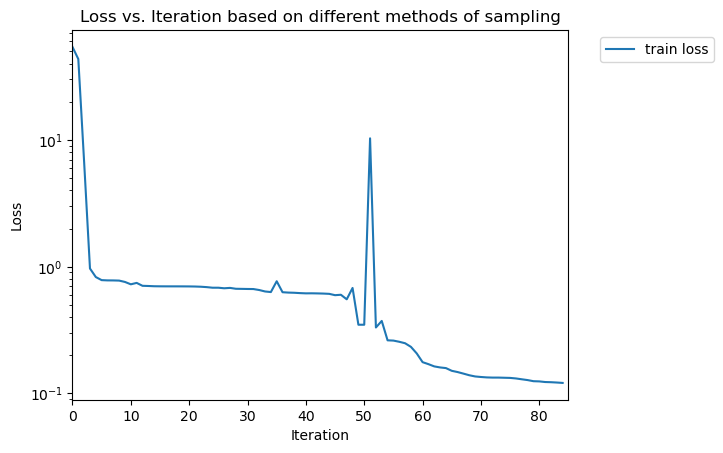

In [ ]:
print(len(trainloss))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


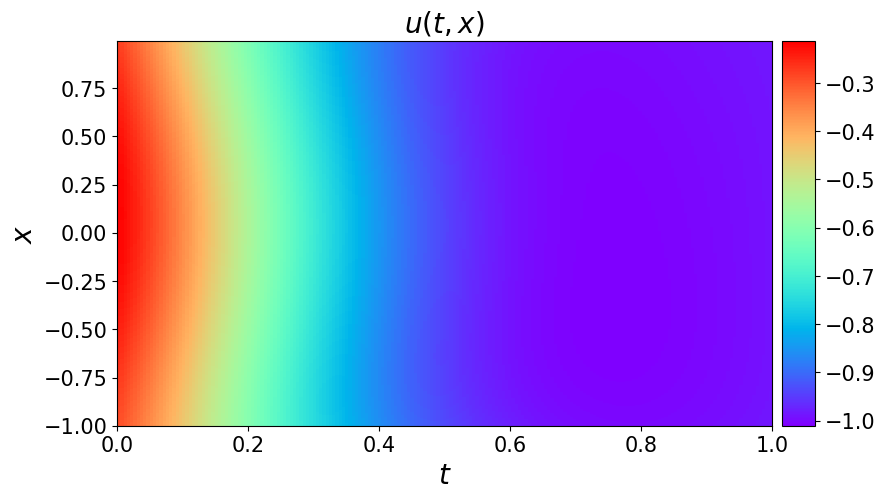

In [ ]:
print(len(testerror))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='loss')
plt.plot(testerror, label='error')
plt.plot(chaos, label='chaos')
# plt.plot(chunchaos, label='chunchaos')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('testerror') # 设置y轴的标签
plt.title('testerror vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

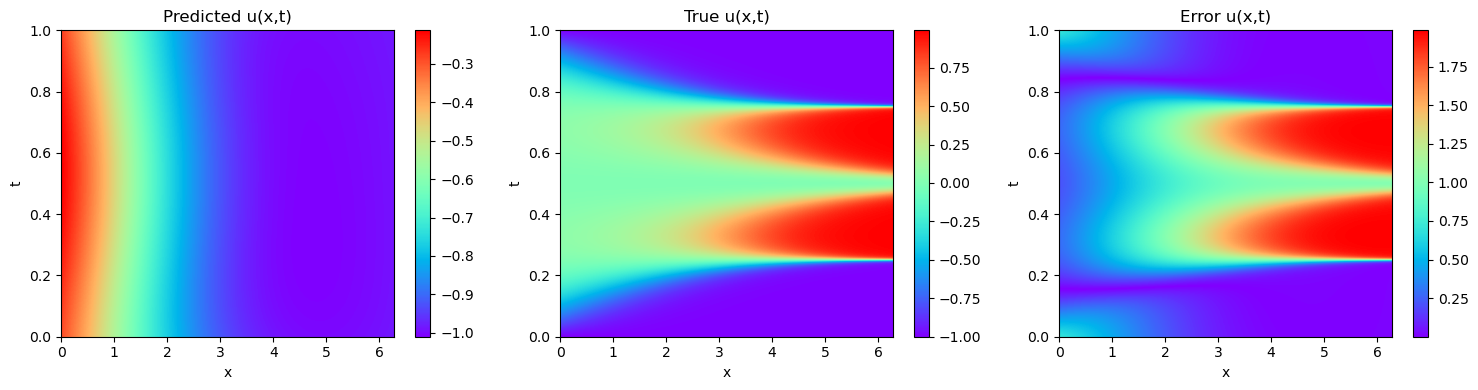

In [ ]:
print(len(testerror))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='loss')
plt.plot(testerror, label='error')
plt.plot(chaos, label='chaos')
# plt.plot(chunchaos, label='chunchaos')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(trainloss)]) # 设置x轴的范围
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('testerror') # 设置y轴的标签
plt.title('testerror vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [ ]:
np.savez('fp64my_training_data.npz', 
         trainloss=trainloss, 
         testerror=testerror, 
        #  chunchaos=chunchaos,
         chaos=chaos)

print("数据已保存到 fp64my_training_data.npz 文件中。")

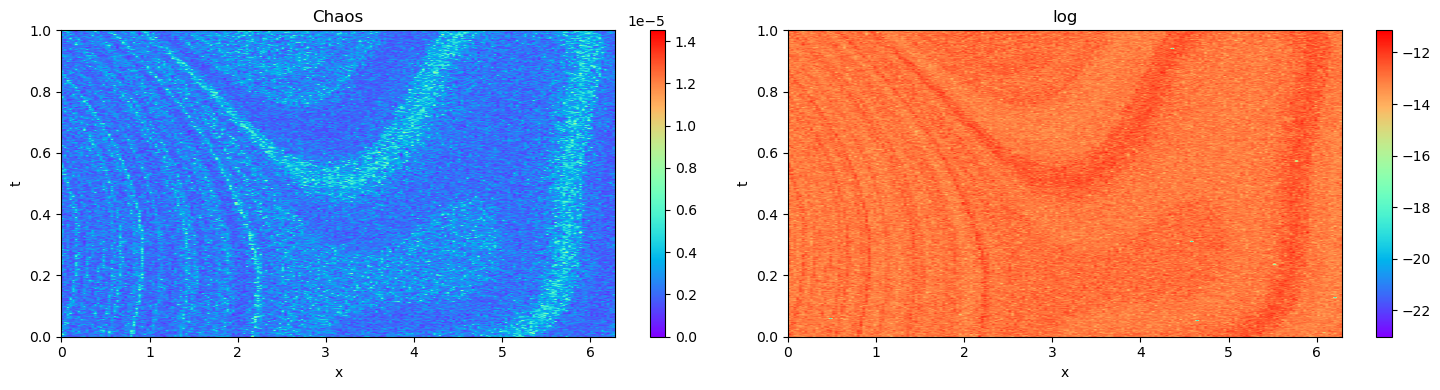

In [ ]:
import numpy as np

# 加载数据
data = np.load('fp64my_training_data.npz')

# 通过保存时使用的键名来访问每个数组
loaded_loss = data['trainloss']
loaded_error = data['testerror']
loaded_chaos = data['chaos']
# loaded_chunchaos = data['chunchaos']

print("加载的训练损失数据长度:", len(loaded_loss))
print("加载的测试误差数据长度:", len(loaded_error))

# 现在你可以用加载的数据进行绘图或分析了

In [ ]:
# print(len(testerror))
# print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(loaded_loss, label='loss')
plt.plot(loaded_error, label='error')
plt.plot(loaded_chaos, label='chaos')
# plt.plot(loaded_chunchaos, label='chunchaos')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,len(loaded_loss)]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('testerror') # 设置y轴的标签
plt.title('testerror vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()